# 1. Functions

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

In [3]:
def print_time(begin_time, end_time):
    """ 
    This function prints the time in minutes that a certain task took.
    """
    print ("--------------------------------------------------")
    print ("CPU process time: %.2f [min]" % float((end-start)/60))
    print ("--------------------------------------------------")

# 2. Packages

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time
import os

In [5]:
my_data = pd.read_csv('../../../Catalogue/binom_reg_dataset.csv')

In [6]:
results_path = '../../../EmLinesModel_Results/'

In [7]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# # parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: 
                                                                                   # UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values[index].astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values[index].astype(float)                  # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [8]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [9]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                       # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

In [10]:
regression_data['X']

array([[ 1.        ,  0.13198   ,  0.01741872, -1.70524698,  2.90786727],
       [ 1.        ,  0.1387    ,  0.01923769,  0.1025686 ,  0.01052032],
       [ 1.        ,  0.17168   ,  0.02947402,  0.31307328,  0.09801488],
       ...,
       [ 1.        ,  0.20231   ,  0.04092934,  1.26636376,  1.60367718],
       [ 1.        ,  0.20539   ,  0.04218505,  0.55180499,  0.30448875],
       [ 1.        ,  0.18752   ,  0.03516375,  0.29910587,  0.08946432]])

In [11]:
# sns.lmplot(x='STELLAR_MASS', y='LOGIT_CLASS(1-UVUP;0-UVWEAK)', data=my_data.iloc[index], logistic=True)
# plt.savefig(os.path.join(results_path, 'logistic_seaborn.pdf'))
# plt.show()

### 2.1 Fit: STAN code 

In [12]:
stan_code = """
// DECLARATION OF VARIABLES ------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) ---------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;         // 25 betas!
//    real<lower=0> sigma;    // Shared hyperpriors
//    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION -----------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

//    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
//    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
       for (j in 1:C) beta[i,j] ~ normal(0, 100);       // priors
        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED ------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### 2.2 Fit settings (for STAN)

In [13]:
iterations = 7000
chains     = 3                           # HMC chains
warmup     = 3000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [14]:
control = {}
control['max_treedepth'] = 30
control['adapt_delta'] = 0.99

### 2.3 Running the fit

In [15]:
start = time.time()

model = pystan.StanModel(model_code=stan_code)

end = time.time()
print_time(start, end)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5cb83d78da90e6f0b257f8fad4560d83 NOW.


--------------------------------------------------
CPU process time: 0.97 [min]
--------------------------------------------------


In [16]:
start = time.time()

fit = model.sampling(data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup, n_jobs=jobs, 
                     control=control)
end = time.time()
print_time(start, end)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--------------------------------------------------
CPU process time: 48.59 [min]
--------------------------------------------------


# 3. Retrieving the data from the fit

### 3.1 Saving the entire fit: brace for impact!

In [17]:
start  = time.time()
fit_df = fit.to_dataframe()
end    = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.10 [min]
--------------------------------------------------


In [18]:
start = time.time()
fit_df.to_csv(os.path.join(results_path, 'entirefit_noshared.csv'), index=False)
end   = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 3.67 [min]
--------------------------------------------------


In [19]:
posteriors = fit_df[fit.flatnames[:25]]
header_posteriors = fit.flatnames[:25]

In [20]:
manual_list = [fit['beta[1,1]'], fit['beta[2,1]'], fit['beta[3,1]'], fit['beta[4,1]'], fit['beta[5,1]'],  
               fit['beta[1,2]'], fit['beta[2,2]'], fit['beta[3,2]'], fit['beta[4,2]'], fit['beta[5,2]'],
               fit['beta[1,3]'], fit['beta[2,3]'], fit['beta[3,3]'], fit['beta[4,3]'], fit['beta[5,3]'],
               fit['beta[1,4]'], fit['beta[2,4]'], fit['beta[3,4]'], fit['beta[4,4]'], fit['beta[5,4]'],
               fit['beta[1,5]'], fit['beta[2,5]'], fit['beta[3,5]'], fit['beta[4,5]'], fit['beta[5,5]']]

/home/mlldantas/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


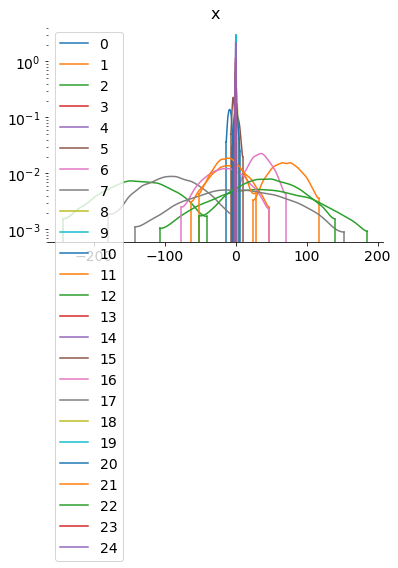

In [21]:
arviz.plot_density(data=manual_list)
plt.yscale('log')
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


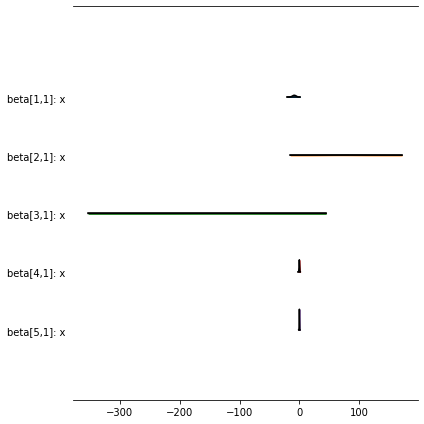

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if sys.path[0] == '':


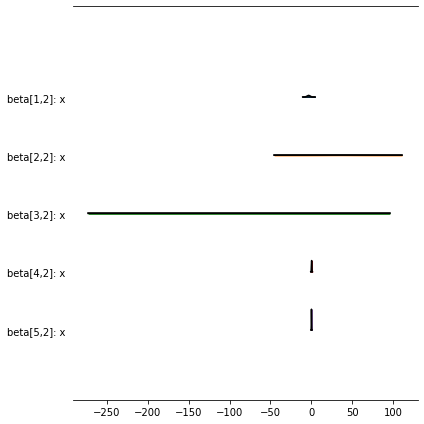

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


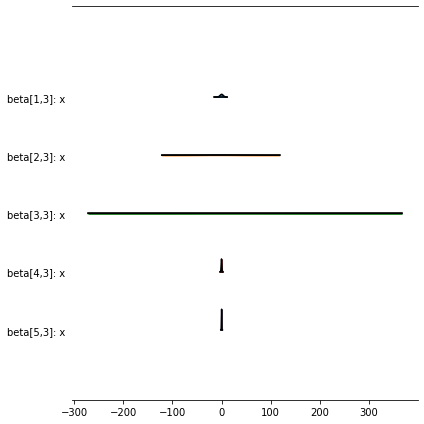

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


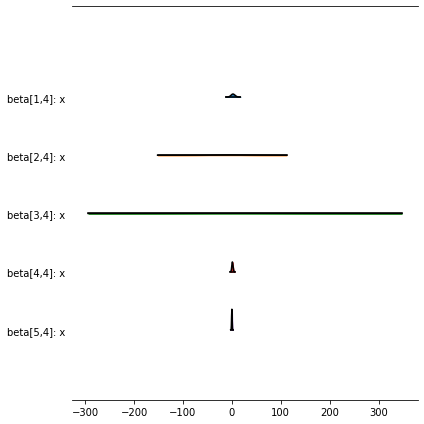

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


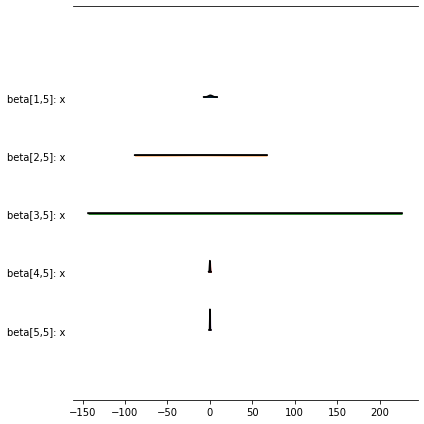

In [22]:
arviz.plot_forest(data=[fit['beta[1,1]'], fit['beta[2,1]'], fit['beta[3,1]'], fit['beta[4,1]'], fit['beta[5,1]']],
                  kind='ridgeplot', model_names=['beta[1,1]', 'beta[2,1]', 'beta[3,1]', 'beta[4,1]', 'beta[5,1]'],
                  figsize=(6,6))
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'betas_noshared_forest01.png'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(results_path, 'betas_noshared_forest01.pdf'), dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,2]'], fit['beta[2,2]'], fit['beta[3,2]'], fit['beta[4,2]'], fit['beta[5,2]']], 
                  kind='ridgeplot', model_names=['beta[1,2]', 'beta[2,2]', 'beta[3,2]', 'beta[4,2]', 'beta[5,2]'], 
                  figsize=(6,6))
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'betas_noshared_forest02.png'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(results_path, 'betas_noshared_forest02.pdf'), dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,3]'], fit['beta[2,3]'], fit['beta[3,3]'], fit['beta[4,3]'], fit['beta[5,3]']], 
                  kind='ridgeplot', model_names=['beta[1,3]', 'beta[2,3]', 'beta[3,3]', 'beta[4,3]', 'beta[5,3]'], 
                  figsize=(6,6))
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'betas_noshared_forest03.png'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(results_path, 'betas_noshared_forest03.pdf'), dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,4]'], fit['beta[2,4]'], fit['beta[3,4]'], fit['beta[4,4]'], fit['beta[5,4]']], 
                  kind='ridgeplot', model_names=['beta[1,4]', 'beta[2,4]', 'beta[3,4]', 'beta[4,4]', 'beta[5,4]'],
                  figsize=(6,6))
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'betas_noshared_forest04.png'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(results_path, 'betas_noshared_forest04.pdf'), dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,5]'], fit['beta[2,5]'], fit['beta[3,5]'], fit['beta[4,5]'], fit['beta[5,5]']], 
                  kind='ridgeplot', model_names=['beta[1,5]', 'beta[2,5]', 'beta[3,5]', 'beta[4,5]', 'beta[5,5]'], 
                  figsize=(6,6))
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'betas_noshared_forest05.png'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(results_path, 'betas_noshared_forest05.pdf'), dpi=150, bbox_inches='tight')
plt.show()

In [23]:
figsize=(6,3)

/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupp

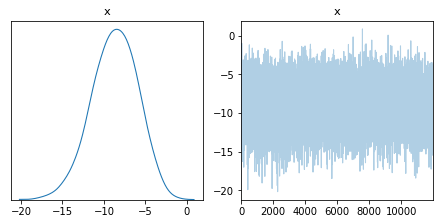

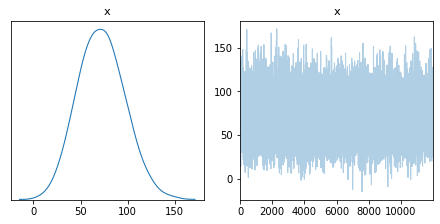

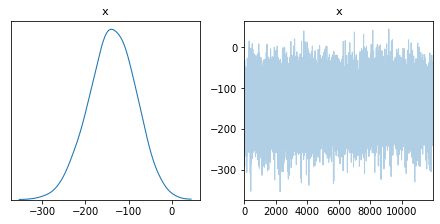

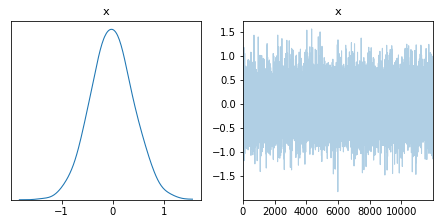

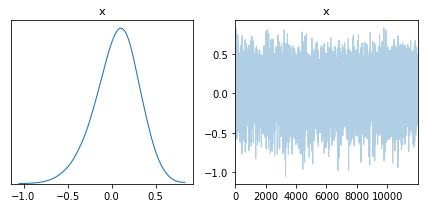

In [24]:
plot = arviz.plot_trace(data=fit['beta[1,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,1]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class01.pdf', bbox_inches='tight')
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupp

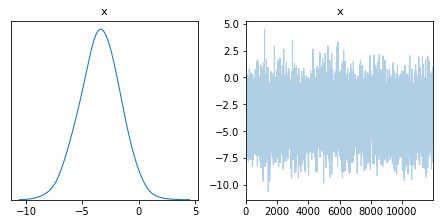

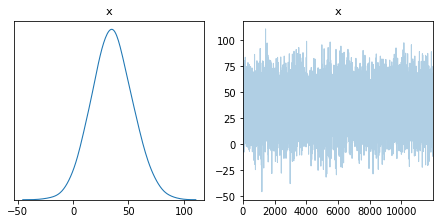

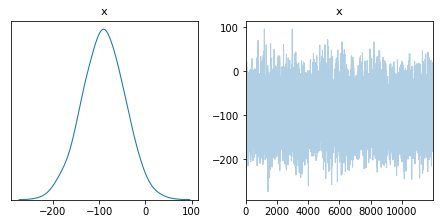

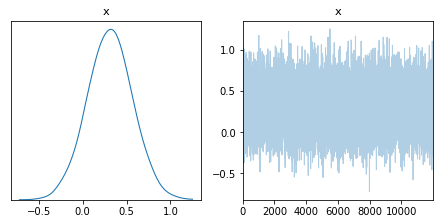

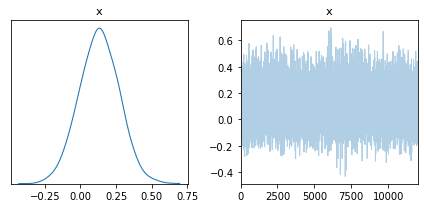

In [25]:
plot = arviz.plot_trace(data=fit['beta[1,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,2]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class02.pdf', bbox_inches='tight')
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupp

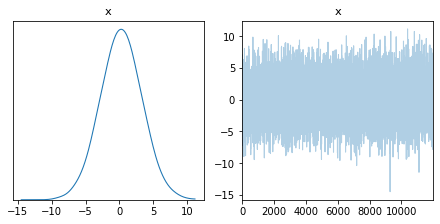

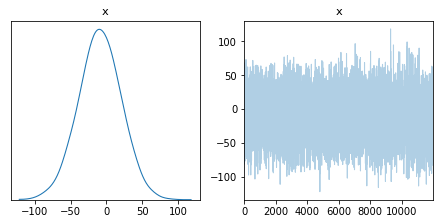

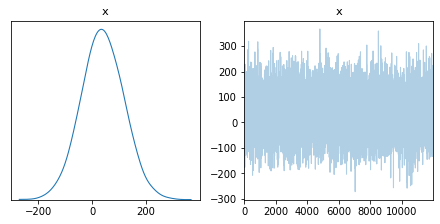

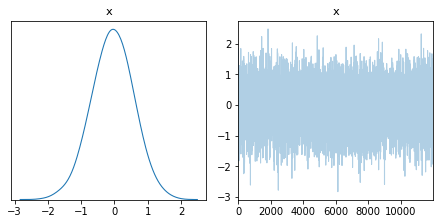

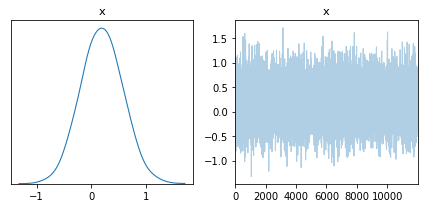

In [26]:
plot = arviz.plot_trace(data=fit['beta[1,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,3]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class03.pdf', bbox_inches='tight')
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupp

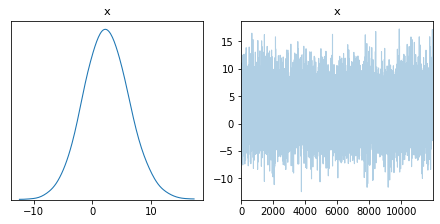

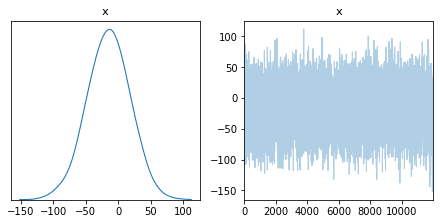

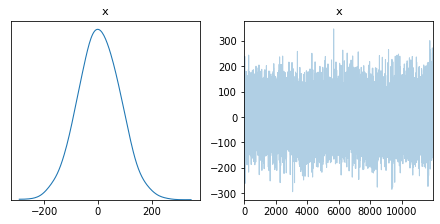

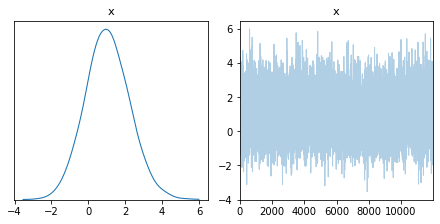

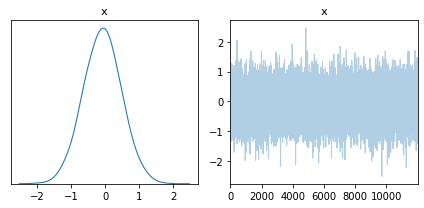

In [27]:
plot = arviz.plot_trace(data=fit['beta[1,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,4]'], figsize=figsize)
# plt.savefig('../../LargeFilesResults/Model/trace_class04.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/mlldantas/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupp

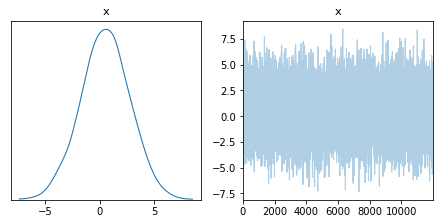

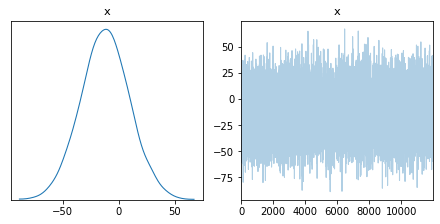

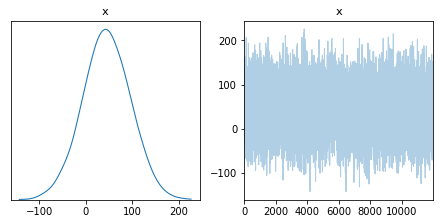

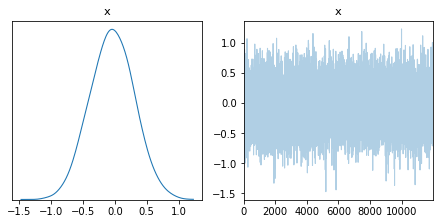

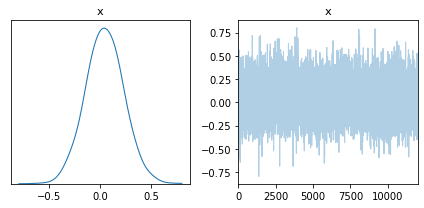

In [28]:
plot = arviz.plot_trace(data=fit['beta[1,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,5]'], figsize=figsize)
# plt.savefig('../../LargeFilesResults/Model/trace_class05.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

### 3.2 Saving the automatic summary from STAN

In [49]:
summary = pystan.stansummary(fit=fit, digits_summary=3)

In [50]:
summary_arr  = np.array(summary.split('\n'))
summary_clean = summary_arr[5:-6,]

In [51]:
header_fit = ['parameter'] + summary_arr[4].split()

#### 3.2.1 Recovering the mass (undo the stadardization) and adding x1 and x2 to the summary

In [52]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
recovered_pars  = np.column_stack((np.squeeze(plot_x1), np.squeeze(recovered_mass)))
rp      = recovered_pars
rp_cols = np.vstack((rp, rp, rp, rp, rp))    # for 5 whan classes we must stack these 5x

In [57]:
# recovered_mass

In [58]:
# recovered_pars

In [120]:
# rp_cols

In [61]:
summary = arviz.summary(data=fit)

In [122]:
indexes = np.array(summary[25:4525].index)
# indexes

In [127]:
header = ['prob'] + list(summary.columns) + ['Z'] + ['LOG_STELLAR_MASS']
# header 

In [128]:
summary_array = np.array(summary[25:4525])
# summary_array

In [131]:
new_summary = np.column_stack((indexes, summary_array))
new_summary = np.column_stack((new_summary, rp_cols))
new_summary = pd.DataFrame(new_summary)
new_summary.columns = header

In [132]:
model_results_df.to_csv(os.path.join(results_path, 'fit_summary_noshared.csv'), header=True, index=True)
new_summary

,prob,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,Z,LOG_STELLAR_MASS
0,prob01[0],0.072,0.113,0,0.289,0.001,0.001,13469,11249,13478,7842,1,0.06794,9.72948
1,prob01[1],0.105,0.15,0,0.413,0.001,0.001,13298,11641,12426,7845,1,0.0776076,9.72948
2,prob01[2],0.146,0.19,0,0.551,0.002,0.001,12738,11636,11506,7883,1,0.0872752,9.72948
3,prob01[3],0.192,0.229,0,0.67,0.002,0.002,12068,11399,10732,7813,1,0.0969428,9.72948
4,prob01[4],0.241,0.262,0,0.774,0.002,0.002,11392,11090,10101,7972,1,0.10661,9.72948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,prob03[895],0.688,0.347,0.036,1,0.003,0.002,12829,12829,13529,9614,1,0.30963,11.6786
4496,prob03[896],0.698,0.345,0.037,1,0.003,0.002,12903,12903,13652,9642,1,0.319297,11.6786
4497,prob03[897],0.707,0.344,0.038,1,0.003,0.002,12937,12937,13729,9742,1,0.328965,11.6786
4498,prob03[898],0.715,0.343,0.037,1,0.003,0.002,12918,12918,13763,9500,1,0.338632,11.6786


In [133]:
posteriors = fit_df[fit.flatnames[:25]]

In [134]:
fit_df.keys()

Index(['chain', 'draw', 'warmup', 'beta[1,1]', 'beta[2,1]', 'beta[3,1]',
       'beta[4,1]', 'beta[5,1]', 'beta[1,2]', 'beta[2,2]',
       ...
       'eta05[898]', 'eta05[899]', 'eta05[900]', 'lp__', 'accept_stat__',
       'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'],
      dtype='object', length=9035)

In [135]:
fit_df['treedepth__'].describe()

count    12000.000000
mean         8.636167
std          0.508737
min          5.000000
25%          8.000000
50%          9.000000
75%          9.000000
max         10.000000
Name: treedepth__, dtype: float64

In [136]:
fit_df['n_leapfrog__'].describe()

count    12000.000000
mean       494.054667
std        179.033394
min         47.000000
25%        511.000000
50%        511.000000
75%        511.000000
max       2047.000000
Name: n_leapfrog__, dtype: float64

In [137]:
posteriors.to_csv(os.path.join(results_path, 'posteriors_noshared.csv'), index=False)

In [138]:
posteriors

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[1,2]","beta[2,2]","beta[3,2]","beta[4,2]","beta[5,2]",...,"beta[1,4]","beta[2,4]","beta[3,4]","beta[4,4]","beta[5,4]","beta[1,5]","beta[2,5]","beta[3,5]","beta[4,5]","beta[5,5]"
0,-12.187872,107.652765,-218.487915,-0.068169,-0.014077,-4.562748,43.272291,-100.723852,0.205079,0.117344,...,5.041107,-59.315118,149.961612,-0.223876,-0.945536,-3.669918,27.459816,-46.362887,-0.397376,0.223145
1,-11.399028,96.402363,-194.169729,-0.350926,0.420846,-2.778258,31.618536,-96.240046,0.395766,0.047736,...,0.102390,-2.660499,-2.127995,0.121996,-0.345262,-2.291965,10.805416,5.558238,-0.632260,-0.059929
2,-10.597359,90.666617,-177.108472,-0.214381,-0.110351,-3.479320,30.153927,-70.409865,0.228308,0.102696,...,-3.142631,37.522926,-120.853234,-0.250283,-0.305395,-0.600042,-1.745767,15.866603,0.031647,0.151940
3,-8.879341,75.106981,-150.363251,0.065239,-0.060980,-1.344217,14.005408,-46.534047,0.358632,0.072889,...,6.298590,-54.760554,95.200227,0.071514,-0.694375,-1.934135,15.978438,-45.563740,0.284740,0.394396
4,-9.004124,73.956605,-148.065263,0.083866,0.220893,-3.148192,33.315412,-92.163772,0.283440,0.066849,...,7.558020,-68.390533,113.705120,2.510280,0.232269,-1.472172,5.751046,12.362552,-0.486874,0.032497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-15.465421,122.108291,-221.573264,-1.085460,0.208655,-4.801607,51.627542,-139.562507,0.459522,0.008677,...,3.381403,-30.012328,57.900324,-0.006807,-0.876589,-0.891898,9.288973,-22.536181,0.196853,-0.117175
11996,-10.715276,94.730537,-205.060459,0.335892,0.162249,-2.999291,26.228714,-57.987963,-0.061056,0.116561,...,-0.089937,7.034398,-78.471547,2.128872,1.151504,-2.669440,14.591370,-14.527528,-0.602625,0.470082
11997,-6.185210,44.998435,-69.224184,-0.448799,0.041381,-2.924115,40.318085,-128.308728,0.475865,0.070427,...,1.078710,17.811415,-127.221029,1.682466,-0.267940,0.932815,-11.350925,37.177402,0.102732,-0.329975
11998,-6.677251,53.167046,-106.692431,0.188847,0.071356,-2.124867,30.125107,-101.200383,0.331939,0.014364,...,-1.415446,7.252188,-28.141180,0.295076,0.281405,1.932720,-28.745412,83.627387,-0.089660,0.032471


In [139]:
diagnostics = pystan.check_hmc_diagnostics(fit, per_chain=True)

In [140]:
diagnostics

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [141]:
pystan.check_hmc_diagnostics??

In [142]:
model_results_df['Rhat'].max()

'X'

In [143]:
model_results_df['Rhat'].min()

'1.0'